In [1]:
%run ../Commons.ipynb

## Config your environment and agent

### TODO: Define the environment

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the variables to falsify
falsify_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
x_original = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [4]:
def build_env(x):
    """
    Create the environment given the deviation parameter in its original (non-normalized) domain.
    """
    return MutatedCartPoleEnv(masscart=x[0], force_mag=x[1])

### TODO: Define Agent

In [5]:
from stable_baselines3 import DQN

model = DQN.load("best_dqn")

In [6]:
# define the action generation function of the given agent
next_action = lambda obs: model.predict(obs, deterministic=True)[0]

# some agents (like PID) needs to be reset for each run
model_reset = None

### TODO: Define STL property

In [7]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def build_stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = (2.4 - pos_range[0]) / (pos_range[1] - pos_range[0])
    angle_threshold = (12 * 2 * np.pi / 360 - angle_range[0]) / (angle_range[1] - angle_range[0])

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def build_stl_trace(records, time_index):
    return {
        "pos": stl.Signal(
            (np.abs(records[:, 0]) - pos_range[0]) / (pos_range[1] - pos_range[0]),
            time_index
        ),
        "angle": stl.Signal(
            (np.abs(records[:, 2]) - angle_range[0]) / (angle_range[1] - angle_range[0]),
            time_index
        )
    }

def is_stl_violated(rob):
    return rob[0] < 0.0

phi = build_stl_prop()

### TODO: Config global options and functions

In [8]:
seed = 19279

# define the max epsiode steps when evaluating a given environment
max_episode_steps = 200

# define the max episodes to run when falsifying a given environment (under some deviation)
max_episodes = 100

# define the target STL robustness value when falsification, i.e., CMA would stop search
# when an instance of such value is found.
stl_falsify_target = 0.0

# timeout in minutes
timeout = 30

# Could change this value for different trials within the total timeout
num_tries = 3

## Robustness analysis starts here!

### The agent should be safe under the original environment by falsification

Is safe!
Deviation: [ 1. 10.]
Deviation distance: 0.0
Initial parameter: [-0.04993601 -0.04996354 -0.04334129 -0.04980284]
Min robustness value: 0.09609257479207878


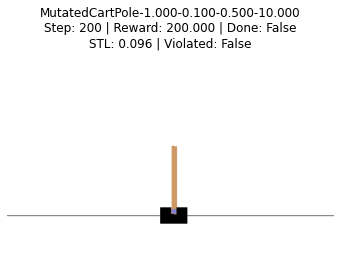

In [9]:
evaluate_dev(x_original, "gifs/default_env.gif")

### CMA for minimizing the STL robustness value given the bounded deviation

In [10]:
x = dev_violates_stl()

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=737130, Fri Aug  5 10:48:37 2022)


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.500000099341070e-01 1.0e+00 3.92e-01  3e-01  4e-01 0:27.0
termination on ftarget=0.0 (Fri Aug  5 10:49:04 2022)
final/bestever f-value = -1.231155e-01 -2.500000e-01
incumbent solution: [0.8039011918326422, 0.314012408466942]
std deviation: [0.4138431979228978, 0.33243397619520537]
CMAEvolutionStrategyResult(xbest=array([0.94111006, 0.31123172]), fbest=-0.250000009934107, evals_best=3, evaluations=7, iterations=1, xfavorite=array([0.80390119, 0.31401241]), stds=array([0.4138432 , 0.33243398]), stop={'ftarget': 0.0})


Deviation: [1.88810912 6.91340273]
Deviation distance: 3.2118251066730643
Initial parameter: [-0.04521629 -0.03818151 -0.03815427 -0.02682559]
Min robustness value: -0.2500000069568836


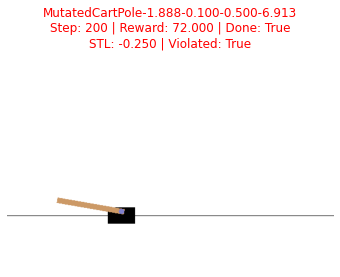

In [11]:
evaluate_dev(x, "gifs/counterexample.gif")

### CMA-ES for minimizing the deviation s.t. the STL is violated.

In [12]:
x = min_dev_violates_stl()


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=833638, Fri Aug  5 10:49:20 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.664330836271327e-04 1.0e+00 2.00e-01  2e-01  2e-01 0:26.9
    2     12 1.920081472336671e-01 1.3e+00 1.67e-01  1e-01  2e-01 0:53.5
    3     18 3.856114754124411e+00 1.4e+00 1.36e-01  1e-01  1e-01 1:25.0
    4     24 3.470161997905027e+00 1.3e+00 2.02e-01  1e-01  2e-01 1:55.7
    5     30 -4.696957113059048e+00 1.3e+00 2.95e-01  2e-01  3e-01 2:17.0
    6     36 -4.122154489039364e+00 1.3e+00 2.56e-01  2e-01  2e-01 2:42.3
    7     42 3.856236487042030e+00 1.2e+00 2.52e-01  2e-01  2e-01 3:12.3
    8     48 3.677766100430968e+00 1.5e+00 2.16e-01  1e-01  2e-01 3:42.3
    9     54 4.363752724313934e+00 1.6e+00 2.18e-01  1e-01  2e-01 4:12.3
   10     60 -4.550023954738258e+00 2.2e+00 3.21e-01  2e-01  3e-01 4:29.7
   11     66 -4.319184203591002e+00 2.5e+00 3.51e-01  2e-01  3e

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: sigma change np.exp(1.0494557788603256) = 2.8560963470229073 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=42)
  warnings.warn(msg + ' (' +


   43    258 6.969593469134510e-01 8.9e+00 9.25e-01  1e-01  3e-01 7:54.4
   44    264 8.659837515472677e-01 7.6e+00 9.00e-01  9e-02  3e-01 8:19.8
   45    270 1.160459170859396e+00 6.0e+00 7.78e-01  7e-02  2e-01 8:49.7
   46    276 1.156018926500326e+00 5.6e+00 6.51e-01  5e-02  1e-01 9:15.2
   47    282 1.348959361613549e+00 5.8e+00 6.11e-01  4e-02  1e-01 9:45.2
   48    288 1.236572029615740e+00 5.6e+00 4.69e-01  3e-02  9e-02 10:11.8
termination on timeout=600.0 (Fri Aug  5 10:59:37 2022)
final/bestever f-value = 1.304841e+00 -4.696957e+00
incumbent solution: [0.730065054648065, 0.44595456993473837]
std deviation: [0.0853447965928391, 0.030603032693151212]
CMAEvolutionStrategyResult(xbest=array([0.01502592, 0.65814463]), fbest=-4.696957113059048, evals_best=30, evaluations=289, iterations=48, xfavorite=array([0.73006505, 0.44595457]), stds=array([0.0853448 , 0.03060303]), stop={'timeout': 600.0})
{'x': array([0.96883102, 0.44339946]), 'f': 1.1027972950220457, 'g': [-0.0037911007831775

Deviation: [1.94077894 9.42458983]
Deviation distance: 1.1027972950220457
Initial parameter: [-0.04838944 -0.04913597 -0.04999007 -0.04868765]
Min robustness value: -0.03670198420984383


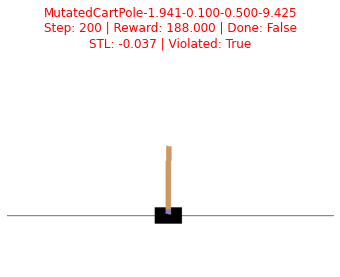

In [13]:
evaluate_dev(x, "gifs/min_dev_counterexample.gif")

### [Optional] CMA for finding the maximum deviation s.t. the agent is safe

In [14]:
x = max_safe_dev()


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=822105, Fri Aug  5 11:20:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.404670639081332e+00 1.0e+00 2.13e-01  2e-01  2e-01 0:26.2
    2     12 -6.579791169738169e+00 1.2e+00 1.69e-01  1e-01  2e-01 0:43.1
    3     18 -1.089101701978866e+01 1.6e+00 2.90e-01  2e-01  4e-01 1:10.2
    4     24 -1.164336588205655e+01 1.9e+00 3.43e-01  2e-01  4e-01 1:40.9
    5     30 -1.050663672955317e+01 1.5e+00 2.74e-01  2e-01  3e-01 2:11.2
    6     36 -1.156907496584996e+01 1.4e+00 2.24e-01  1e-01  2e-01 2:41.3
    7     42 -1.122618945817696e+01 1.3e+00 2.03e-01  1e-01  1e-01 3:11.3
    8     48 -1.161675309727726e+01 1.2e+00 1.88e-01  1e-01  1e-01 3:41.4
    9     54 -1.162782513650695e+01 1.4e+00 1.57e-01  8e-02  9e-02 4:11.6
   10     60 -1.165588073083170e+01 1.1e+00 1.17e-01  5e-02  6e-02 4:41.7
   11     66 -1.162115387763676e+01 1.2e+00 1.12e-01  5e

Is safe!
Deviation: [ 1.60916703 19.98678952]
Deviation distance: 10.005351037873112
Initial parameter: [-0.04972802 -0.04943774 -0.04725719 -0.04811722]
Min robustness value: 0.09504323502080803


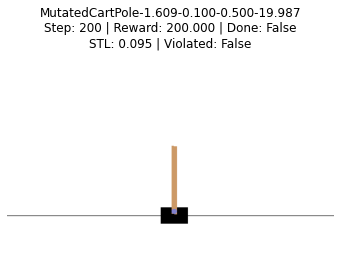

In [15]:
evaluate_dev(x, "gifs/max_safe_deviation.gif")

### Plot the shape of the optimization space using grid

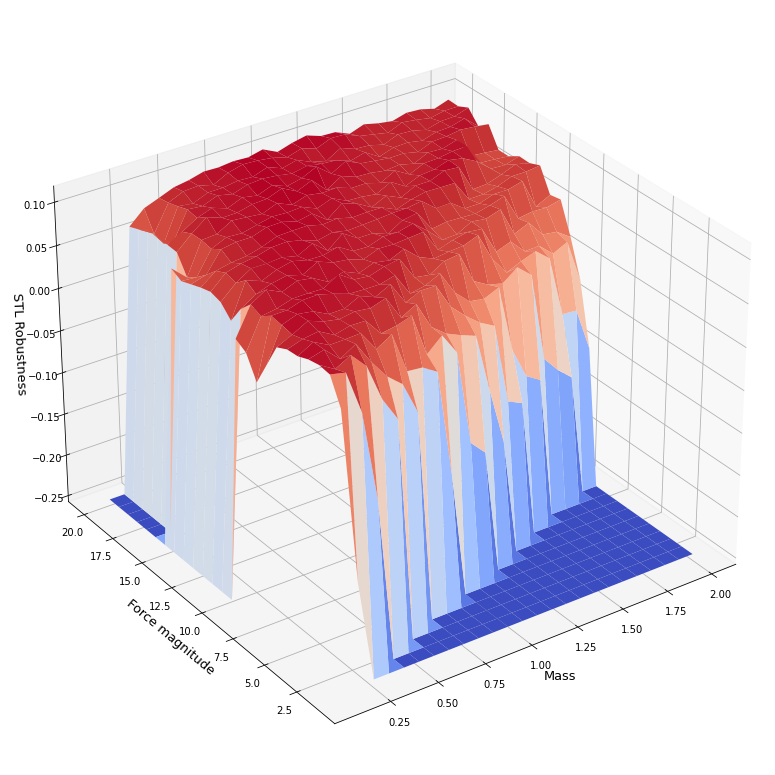

In [16]:
stl_falsify_target = -np.inf
ax, masses, forces, grid_data = grid_plot(masscart, force_mag, 25, 25, x_name="masses", y_name="forces")
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

### Using accelaration to understand the plot

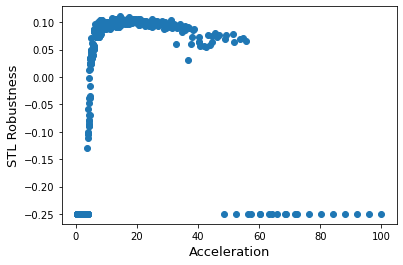

In [17]:
acc = forces / (masses + 0.1)
plt.scatter(acc.flatten(), grid_data.flatten())
plt.xlabel('Acceleration', fontsize=13)
plt.ylabel('STL Robustness', fontsize=13)
plt.savefig('gifs/robustness-landscape-acc.png')

In [18]:
# the overlap part with positive robustness
idx = np.logical_and(grid_data > 0.05, acc > 50)
overlap_pos = np.stack((masses[idx], forces[idx]), axis=1); overlap_pos

array([[ 0.17916667, 14.45833333],
       [ 0.17916667, 15.25      ],
       [ 0.25833333, 18.41666667],
       [ 0.25833333, 19.20833333],
       [ 0.25833333, 20.        ]])

Is safe!
Deviation: [ 0.25833333 20.        ]
Deviation distance: 10.02746575384052
Initial parameter: [-0.04992497 -0.04946066 -0.04541054 -0.04947813]
Min robustness value: 0.06316458483236198


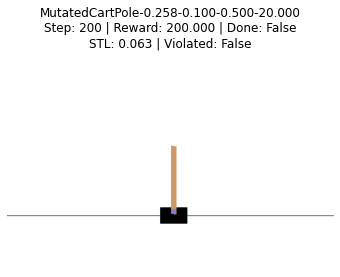

In [19]:
evaluate_dev(overlap_pos[-1], "gifs/overlap_pos.gif")

In [20]:
# the overlap part with negative robustness
idx = np.logical_and(np.logical_and(grid_data < 0, acc > 40), acc < 55)
overlap_neg = np.stack((masses[idx], forces[idx]), axis=1); overlap_neg

array([[ 0.1       ,  9.70833333],
       [ 0.1       , 10.5       ]])

Deviation: [0.1        9.70833333]
Deviation distance: 0.9460810982386474
Initial parameter: [-0.03638988 -0.04856365 -0.04665466 -0.02318398]
Min robustness value: -0.250000009934107


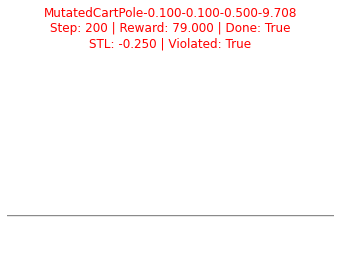

In [21]:
evaluate_dev(overlap_neg[0], "gifs/overlap_neg.gif")

### Compare with PID

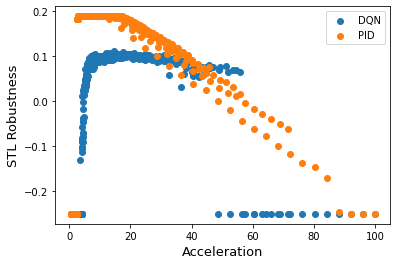

In [22]:
pid_data = np.loadtxt("../cartpole-pid/data/grid_data.csv", delimiter=",")
plt.scatter(acc.flatten(), grid_data.flatten(), label="DQN")
plt.scatter(acc.flatten(), pid_data.flatten(), label="PID")
plt.legend()
plt.xlabel('Acceleration', fontsize=13)
plt.ylabel('STL Robustness', fontsize=13)
plt.savefig('gifs/robustness-landscape-acc-compare.png')

### Zoom in the plot

In [23]:
if not os.path.exists('data/masses_zoomin.csv'):
    n_mass, n_force = (10, 10)
    masses = np.linspace(0.9, 1.1, n_mass)
    forces = np.linspace(9, 11, n_force)
    masses, forces = np.meshgrid(masses, forces, indexing='ij')
    
    stl_falsify_target = -np.inf
    grid_data = np.zeros((n_mass, n_force))

    for i in range(n_mass):
        for j in range(n_force):
            # treat xv[i,j], yv[i,j]
            m, f = masses[i, j], forces[i, j]
            robustness, _ = falsification_by_CMA([m, f])
            grid_data[i, j] = robustness
    
    np.savetxt("data/masses_zoomin.csv", masses, delimiter=",")
    np.savetxt("data/forces_zoomin.csv", forces, delimiter=",")
    np.savetxt("data/grid_data_zoomin.csv", grid_data, delimiter=",")
else:
    masses = np.loadtxt("data/masses_zoomin.csv", delimiter=",")
    forces = np.loadtxt("data/forces_zoomin.csv", delimiter=",")
    grid_data = np.loadtxt("data/grid_data_zoomin.csv", delimiter=",")

In [24]:
masses_pid = np.loadtxt("../cartpole-pid/data/masses_zoomin.csv", delimiter=",")
forces_pid = np.loadtxt("../cartpole-pid/data/forces_zoomin.csv", delimiter=",")
grid_data_pid = np.loadtxt("../cartpole-pid/data/grid_data_zoomin.csv", delimiter=",")

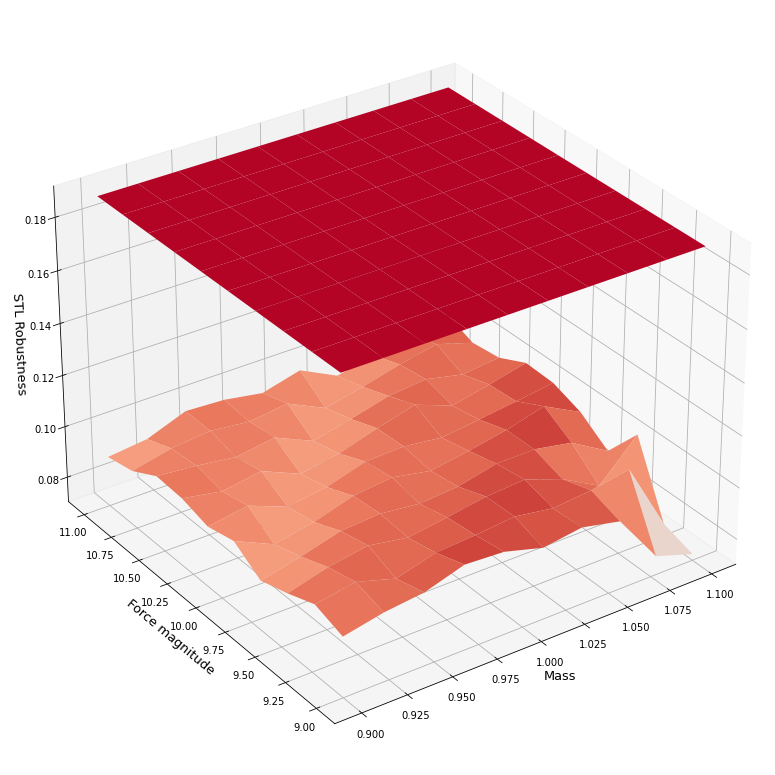

In [25]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))
ax.plot_surface(masses, forces, grid_data, cmap=cm.coolwarm,
                vmax=grid_data.max(), vmin=grid_data.max()-0.05)
ax.plot_surface(masses_pid, forces_pid, grid_data_pid, cmap=cm.coolwarm,
                vmax=grid_data_pid.max(), vmin=grid_data_pid.max()-0.05)
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.set_zlabel('STL Robustness', fontsize=13)
ax.set_zlim(grid_data.min(), grid_data_pid.max())
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-compare-zoomin.png')
plt.show()